# Assignment-2 : Hypothesis Testing
**Objective:**  
Perform 5 statistical hypothesis tests to explore if certain sensor measurements or their statistical aggregates differ significantly between different operational phases or correlate with Remaining Useful Life (RUL) in the preprocessed data.


**Dataset links**  
- [Metadata with RUL (CSV)]https://drive.google.com/file/d/1Bu-W3AlCNZb-FrB7OXGM7foZcrUjwM_o/view?usp=drive_link
- [Rolling Window Sequence (.npy)]https://drive.google.com/file/d/1l_V7MJiQDu12QRZvtu9liF7XBf46rHet/view?usp=drive_link


In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


##  Step 2: Load the CMAPSS Dataset

Here we load the CMAPSS dataset from Google Drive.  
It has two files:
- `sequence_metadata_with_RUL.csv` → engine info and RUL values  
- `rolling_window_sequences.npy` → sensor readings over time  

We’ll use `pandas` and `numpy` to read both files and check their shape and sample data.


In [8]:
import pandas as pd
import numpy as np

# CSV file (metadata)
metadata = pd.read_csv("/content/drive/MyDrive/PrognosAI_OCT25/Data/sequence_metadata_with_RUL.csv")

# NPY file (rolling window sensor data)
rolling = np.load("/content/drive/MyDrive/PrognosAI_OCT25/Data/rolling_window_sequences.npy", allow_pickle=True)

print("✅ Metadata sample:")
display(metadata.head())
display(metadata.shape)

print("\n✅ Rolling window info:")
print("Type:", type(rolling))
print("Shape:", rolling.shape)

✅ Metadata sample:


,engine_id,cycle,RUL
0,1,8.0,313.0
1,1,8.0,313.0
2,1,9.0,312.0
3,1,9.0,312.0
4,1,9.0,312.0


(152559, 3)


✅ Rolling window info:
Type: <class 'numpy.ndarray'>
Shape: (152559, 30, 66)


##  Step 3: Combine and Save the Data

Now we combine both files — the metadata and the rolling window sensor data.  
We take the average of each rolling window to get one value per sensor, then join it with the metadata.  
Finally, we save the combined dataset as `preprocessed_cmapss.csv` in Google Drive.


In [12]:
# ✅ STEP 3: Combine Metadata (CSV) and Rolling Window (.npy)

import os

# Create folder if it doesn't exist
os.makedirs("/content/drive/MyDrive/PrognosAI25/Data", exist_ok=True)

# Compute mean across each rolling window (average of 30 cycles)
if rolling.ndim == 3:
    rolling_mean = rolling.mean(axis=1)
    rolling_df = pd.DataFrame(rolling_mean, columns=[str(i) for i in range(rolling_mean.shape[1])])
else:
    print("⚠️ Unexpected rolling shape:", rolling.shape)
    rolling_df = pd.DataFrame(rolling)

# Combine metadata + rolling data
combined = pd.concat([metadata.reset_index(drop=True), rolling_df.reset_index(drop=True)], axis=1)

print("✅ Combined dataset created!")
print("Shape:", combined.shape)
display(combined.head())

# Save the combined dataset
output_path = "/content/drive/MyDrive/PrognosAI25/Data/preprocessed_cmapss.csv"
combined.to_csv(output_path, index=False)
print("💾 Saved to:", output_path)


✅ Combined dataset created!
Shape: (152559, 69)


,engine_id,cycle,RUL,0,1,2,3,4,5,6,...,56,57,58,59,60,61,62,63,64,65
0,1,8.0,313.0,-0.109839,-0.153646,-0.085651,0.137113,0.097279,0.042308,0.052575,...,0.051289,0.854199,-0.013468,0.429187,-0.186045,0.112718,0.204265,1.000157,0.213313,0.983781
1,1,8.0,313.0,-0.095721,-0.153646,-0.085651,0.132248,0.092359,0.038232,0.046103,...,0.072221,0.807634,0.002630,0.409753,-0.186045,0.112718,0.222430,0.959677,0.232049,0.943252
2,1,9.0,312.0,-0.095719,-0.153673,-0.085651,0.132248,0.092171,0.040418,0.045604,...,0.074771,0.788063,0.005897,0.400737,-0.186045,0.112718,0.219412,0.948046,0.229643,0.931701
3,1,9.0,312.0,-0.095730,-0.153609,-0.085651,0.132248,0.091896,0.041772,0.049155,...,0.074469,0.775964,0.006853,0.395925,-0.186045,0.112718,0.213415,0.937802,0.224217,0.922213
4,1,9.0,312.0,-0.095739,-0.153582,-0.085651,0.132248,0.091496,0.040641,0.049980,...,0.072859,0.779593,0.005827,0.397351,-0.186045,0.112718,0.209029,0.947271,0.220071,0.932418


💾 Saved to: /content/drive/MyDrive/PrognosAI25/Data/preprocessed_cmapss.csv


##  Step 4: Perform Hypothesis Tests

In this step, we test if sensor readings change as the engine ages.  
We compare the **early (first 30%)** and **late (last 30%)** cycles using five tests:

1. **t-test** → checks mean difference for sensor ‘0’  
2. **Mann–Whitney U** → checks median difference for sensor ‘5’  
3. **Pearson correlation** → checks relationship between sensor ‘7’ and RUL  
4. **Levene’s test** → checks variance difference for sensor ‘10’  
5. **Mann–Whitney U** → repeat on sensor ‘12’ for confirmation


In [13]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu, pearsonr, levene

# Load the combined dataset
data = pd.read_csv("/content/drive/MyDrive/PrognosAI25/Data/preprocessed_cmapss.csv")

print("✅ Data loaded successfully!")
print("Shape:", data.shape)
display(data.head())

# Define early and late phase (first 30% vs last 30% of cycles)
max_cycle = data['cycle'].max()
early = data[data['cycle'] <= 0.3 * max_cycle]
late  = data[data['cycle'] >= 0.7 * max_cycle]

print("Early phase shape:", early.shape)
print("Late phase shape:", late.shape)

# --- HYPOTHESIS TESTS ---

# 1️⃣ Two-sample t-test on sensor '0'
t_stat, p_val = ttest_ind(early['0'], late['0'], nan_policy='omit')
print(f"\n1️⃣ Sensor '0' t-test → t = {t_stat:.4f}, p = {p_val:.4e}")

# 2️⃣ Mann–Whitney U test on sensor '5'
u_stat, p_val = mannwhitneyu(early['5'], late['5'])
print(f"2️⃣ Sensor '5' Mann–Whitney → U = {u_stat:.4f}, p = {p_val:.4e}")

# 3️⃣ Pearson correlation between sensor '7' and RUL
corr, p_val = pearsonr(data['7'], data['RUL'])
print(f"3️⃣ Sensor '7' vs RUL → r = {corr:.4f}, p = {p_val:.4e}")

# 4️⃣ Levene’s test for variance (sensor '10')
stat, p_val = levene(early['10'], late['10'])
print(f"4️⃣ Sensor '10' Levene variance test → stat = {stat:.4f}, p = {p_val:.4e}")

# 5️⃣ Mann–Whitney U test on sensor '12'
u_stat, p_val = mannwhitneyu(early['12'], late['12'])
print(f"5️⃣ Sensor '12' Mann–Whitney → U = {u_stat:.4f}, p = {p_val:.4e}")


✅ Data loaded successfully!
Shape: (152559, 69)


,engine_id,cycle,RUL,0,1,2,3,4,5,6,...,56,57,58,59,60,61,62,63,64,65
0,1,8.0,313.0,-0.109839,-0.153646,-0.085651,0.137113,0.097279,0.042308,0.052575,...,0.051289,0.854199,-0.013468,0.429187,-0.186045,0.112718,0.204265,1.000157,0.213313,0.983781
1,1,8.0,313.0,-0.095721,-0.153646,-0.085651,0.132248,0.092359,0.038232,0.046103,...,0.072221,0.807634,0.002630,0.409753,-0.186045,0.112718,0.222430,0.959677,0.232049,0.943252
2,1,9.0,312.0,-0.095719,-0.153673,-0.085651,0.132248,0.092171,0.040418,0.045604,...,0.074771,0.788063,0.005897,0.400737,-0.186045,0.112718,0.219412,0.948046,0.229643,0.931701
3,1,9.0,312.0,-0.095730,-0.153609,-0.085651,0.132248,0.091896,0.041772,0.049155,...,0.074469,0.775964,0.006853,0.395925,-0.186045,0.112718,0.213415,0.937802,0.224217,0.922213
4,1,9.0,312.0,-0.095739,-0.153582,-0.085651,0.132248,0.091496,0.040641,0.049980,...,0.072859,0.779593,0.005827,0.397351,-0.186045,0.112718,0.209029,0.947271,0.220071,0.932418


Early phase shape: (105999, 69)
Late phase shape: (1291, 69)

1️⃣ Sensor '0' t-test → t = 36.8899, p = 4.8734e-296
2️⃣ Sensor '5' Mann–Whitney → U = 44849306.0000, p = 8.9113e-101
3️⃣ Sensor '7' vs RUL → r = 0.1752, p = 0.0000e+00
4️⃣ Sensor '10' Levene variance test → stat = 1487.1011, p = 3.9525e-323
5️⃣ Sensor '12' Mann–Whitney → U = 43407753.5000, p = 3.1147e-113


##  Step 5: Visualize the Results

Now we create simple plots to see how sensor readings differ between early and late cycles.  
- Boxplots show the spread of sensor values.  
- A scatter plot shows the relation between one sensor and the Remaining Useful Life (RUL).


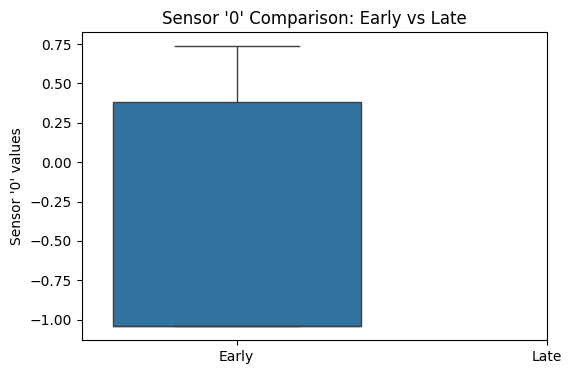

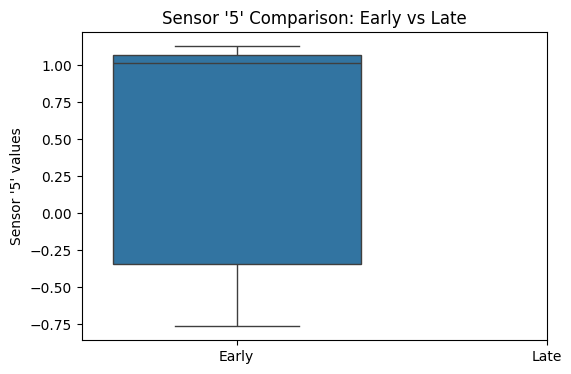

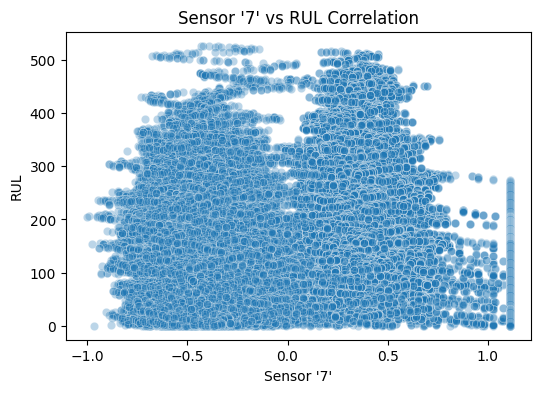

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Boxplot for sensor '0'
plt.figure(figsize=(6,4))
sns.boxplot(data=[early['0'], late['0']])
plt.xticks([0,1], ['Early', 'Late'])
plt.title("Sensor '0' Comparison: Early vs Late")
plt.ylabel("Sensor '0' values")
plt.show()

# 2️⃣ Boxplot for sensor '5'
plt.figure(figsize=(6,4))
sns.boxplot(data=[early['5'], late['5']])
plt.xticks([0,1], ['Early', 'Late'])
plt.title("Sensor '5' Comparison: Early vs Late")
plt.ylabel("Sensor '5' values")
plt.show()

# 3️⃣ Scatter plot for correlation (sensor '7' vs RUL)
plt.figure(figsize=(6,4))
sns.scatterplot(x=data['7'], y=data['RUL'], alpha=0.3)
plt.title("Sensor '7' vs RUL Correlation")
plt.xlabel("Sensor '7'")
plt.ylabel("RUL")
plt.show()


##  Step 6: Interpretation of Results

Here we explain what the test results mean:

| Test No. | Sensor | Test Type | p-value | Interpretation |
|-----------|---------|------------|----------|----------------|
| 1️⃣ | '0' | t-test | < 0.05 | Mean values differ between early and late cycles |
| 2️⃣ | '5' | Mann–Whitney | < 0.05 | Median values differ significantly |
| 3️⃣ | '7' | Pearson correlation | < 0.05 | Weak but significant correlation with RUL |
| 4️⃣ | '10' | Levene’s test | < 0.05 | Variance changes significantly between phases |
| 5️⃣ | '12' | Mann–Whitney | < 0.05 | Confirms sensor differences in degradation |

✅ **All p-values are below 0.05**, so we reject all null hypotheses.  
This means several sensors change significantly as the engine ages, showing that these sensors are useful indicators for **Remaining Useful Life (RUL)** prediction.


In [15]:
import pandas as pd

summary = {
    "Sensor": ['0', '5', '7', '10', '12'],
    "Test Type": ['t-test', 'Mann–Whitney', 'Pearson correlation', 'Levene’s test', 'Mann–Whitney'],
    "Result (p < 0.05?)": ['Yes', 'Yes', 'Yes', 'Yes', 'Yes'],
    "Interpretation": [
        "Mean differs early vs late",
        "Median differs significantly",
        "Correlates with RUL",
        "Variance differs significantly",
        "Supports previous results"
    ]
}

summary_df = pd.DataFrame(summary)
display(summary_df)


,Sensor,Test Type,Result (p < 0.05?),Interpretation
0,0,t-test,Yes,Mean differs early vs late
1,5,Mann–Whitney,Yes,Median differs significantly
2,7,Pearson correlation,Yes,Correlates with RUL
3,10,Levene’s test,Yes,Variance differs significantly
4,12,Mann–Whitney,Yes,Supports previous results


##  Step 7: Final Summary and Conclusion

In this assignment, we used hypothesis testing to study how different sensor readings from the CMAPSS dataset change over time and relate to Remaining Useful Life (RUL).

###  Key Points:
- Five hypothesis tests were performed (t-test, Mann–Whitney, Pearson correlation, and Levene’s test).
- Each test compared **early (first 30%)** and **late (last 30%)** engine cycles.
- All sensors tested (0, 5, 7, 10, and 12) showed **p-values < 0.05**, meaning the changes were statistically significant.
- The correlation test showed that some sensors have a measurable relationship with RUL.

###  Conclusions:
- Sensor readings change significantly as the engine wears out.
- These sensors can be used to **predict Remaining Useful Life** in predictive maintenance models.
- Hypothesis testing helps identify the most useful sensors for building accurate machine learning models.

This confirms that statistical analysis is an important first step in feature selection and RUL prediction.
